In [1]:
# Install diffusers
!pip install transformers diffusers accelerate -U
!pip install parediffusers==0.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 87.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 96.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 44.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.3.0
    Uninstalling fsspec-2023.3.0:
      Successfully uninstalled fsspec-2023.3.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.1
    Uninstalling huggingface-hub-0.13.1:
      Successfully uninstalled huggingface-hub-0.13.1
  Attempting uninstall: tokenizers
    Found existing installation: toke

# Part 1: Run previous to check it.

In [5]:
import torch
from parediffusers import PareDiffusionPipeline

@torch.no_grad()
def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
	"""
	Iteratively denoise the latent space using the diffusion model to produce an image.
	"""
	timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)

	for t in timesteps:
		latent_model_input = torch.cat([latents] * 2)
		noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

		# Update latents by reversing the diffusion process for the current timestep
		latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

	return latents

PareDiffusionPipeline.denoise = denoise

In [6]:
import torch

device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"
width = 512
height = 512
num_inference_steps = 50
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"


pipe = PareDiffusionPipeline.from_pretrained(model_name)

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [21]:
import json
import torch
import torch.nn as nn
from typing import List, Union
from huggingface_hub import hf_hub_download

DEFAULT_UNET_CONFIG = {
	"in_channels": 4,
	"out_channels": 4,
	"sample_size": 96,
	"center_input_sample": False,
	"flip_sin_to_cos": True,
	"freq_shift": 0,
	"down_block_types": [
		"CrossAttnDownBlock2D",
		"CrossAttnDownBlock2D",
		"CrossAttnDownBlock2D",
		"DownBlock2D",
	],
	"mid_block_type": "UNetMidBlock2DCrossAttn",
	"up_block_types": [
		"UpBlock2D",
		"CrossAttnUpBlock2D",
		"CrossAttnUpBlock2D",
		"CrossAttnUpBlock2D",
	],
	"only_cross_attention": False,
	"block_out_channels": [320, 640, 1280, 1280],
	"layers_per_block": 2,
	"downsample_padding": 1,
	"mid_block_scale_factor": 1,
	"dropout": 0.0,
	"act_fn": "silu",
	"norm_num_groups": 32,
	"norm_eps": 1e-5,
	"cross_attention_dim": 1024,
	"transformer_layers_per_block": 1,
	"reverse_transformer_layers_per_block": None,
	"encoder_hid_dim": None,
	"encoder_hid_dim_type": None,
	"attention_head_dim": [5, 10, 20, 20],
	"num_attention_heads": None,
	"dual_cross_attention": False,
	"use_linear_projection": True,
	"class_embed_type": None,
	"addition_embed_type": None,
	"addition_time_embed_dim": None,
	"num_class_embeds": None,
	"upcast_attention": False,
	"resnet_time_scale_shift": "default",
	"resnet_skip_time_act": False,
	"resnet_out_scale_factor": 1.0,
	"time_embedding_type": "positional",
	"time_embedding_dim": None,
	"time_embedding_act_fn": None,
	"timestep_post_act": None,
	"time_cond_proj_dim": None,
	"conv_in_kernel": 3,
	"conv_out_kernel": 3,
	"projection_class_embeddings_input_dim": None,
	"attention_type": "default",
	"class_embeddings_concat": False,
	"mid_block_only_cross_attention": None,
	"cross_attention_norm": None,
	"addition_embed_type_num_heads": 64,
	"_use_default_values": [
		"timestep_post_act",
		"addition_time_embed_dim",
		"conv_out_kernel",
		"encoder_hid_dim",
		"transformer_layers_per_block",
		"conv_in_kernel",
		"time_cond_proj_dim",
		"resnet_out_scale_factor",
		"only_cross_attention",
		"num_class_embeds",
		"upcast_attention",
		"mid_block_only_cross_attention",
		"time_embedding_type",
		"encoder_hid_dim_type",
		"num_attention_heads",
		"class_embed_type",
		"attention_type",
		"reverse_transformer_layers_per_block",
		"cross_attention_norm",
		"mid_block_type",
		"resnet_time_scale_shift",
		"addition_embed_type",
		"dropout",
		"class_embeddings_concat",
		"addition_embed_type_num_heads",
		"resnet_skip_time_act",
		"projection_class_embeddings_input_dim",
		"time_embedding_dim",
		"time_embedding_act_fn",
	],
	"_class_name": "UNet2DConditionModel",
	"_diffusers_version": "0.8.0",
	"_name_or_path": "stabilityai/stable-diffusion-2",	
}

ACTIVATION_FUNCTIONS = {
	"swish": nn.SiLU(),
	"silu": nn.SiLU(),
	"mish": nn.Mish(),
	"gelu": nn.GELU(),
	"relu": nn.ReLU(),
}

class DotDict(dict):
	"""dot.notation access to dictionary attributes"""
	__getattr__ = dict.get
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

def get_activation(act_fn: str) -> nn.Module:
	act_fn = act_fn.lower()
	if act_fn in ACTIVATION_FUNCTIONS:
		return ACTIVATION_FUNCTIONS[act_fn]
	else:
		raise ValueError(f"Unsupported activation function: {act_fn}")

class PareUNet2DConditionModel(nn.Module):
	def __init__(self, **kwargs):
		super().__init__()
		self.config = DotDict(DEFAULT_UNET_CONFIG)
		self.config.update(kwargs)
		self.config.only_cross_attention = [self.config.only_cross_attention] * len(self.config.down_block_types)
		self.config.num_attention_heads = self.config.num_attention_heads or self.config.attention_head_dim
		self._setup_model_parameters()

		self._build_input_layers()
		self._build_time_embedding()
		self._build_down_blocks()
		self._build_mid_block()
		self._build_up_blocks()
		self._build_output_layers()

	def _setup_model_parameters(self) -> None:
		if isinstance(self.config.num_attention_heads, int):
			self.config.num_attention_heads = (self.config.num_attention_heads,) * len(self.config.down_block_types)
		if isinstance(self.config.attention_head_dim, int):
			self.config.attention_head_dim = (self.config.attention_head_dim,) * len(self.config.down_block_types)
		if isinstance(self.config.cross_attention_dim, int):
			self.config.cross_attention_dim = (self.config.cross_attention_dim,) * len(self.config.down_block_types)
		if isinstance(self.config.layers_per_block, int):
			self.config.layers_per_block = [self.config.layers_per_block] * len(self.config.down_block_types)
		if isinstance(self.config.transformer_layers_per_block, int):
			self.config.transformer_layers_per_block = [self.config.transformer_layers_per_block] * len(self.config.down_block_types)

	def _build_input_layers(self) -> None:
		conv_in_padding = (self.config.conv_in_kernel - 1) // 2
		self.conv_in = nn.Conv2d(
			self.config.in_channels, self.config.block_out_channels[0], kernel_size=self.config.conv_in_kernel, padding=conv_in_padding
		)

	def _build_time_embedding(self) -> None:
		self.config.time_embed_dim = self.config.time_embedding_dim or self.config.block_out_channels[0] * 4
		self.time_proj = PareTimesteps(self.config.block_out_channels[0], self.config.flip_sin_to_cos, self.config.freq_shift)
		timestep_input_dim = self.config.block_out_channels[0]

		self.time_embedding = PareTimestepEmbedding(
			timestep_input_dim,
			self.config.time_embed_dim,
			act_fn=self.config.act_fn,
			post_act_fn=self.config.timestep_post_act,
			cond_proj_dim=self.config.time_cond_proj_dim,
		)

	def _build_down_blocks(self) -> None:
		self.down_blocks = nn.ModuleList([])
		output_channel = self.config.block_out_channels[0]
		for i, down_block_type in enumerate(self.config.down_block_types):
			input_channel = output_channel
			output_channel = self.config.block_out_channels[i]
			is_final_block = i == len(self.config.block_out_channels) - 1

			down_block = pare_get_down_block(
				down_block_type,
				num_layers=self.config.layers_per_block[i],
				transformer_layers_per_block=self.config.transformer_layers_per_block[i],
				in_channels=input_channel,
				out_channels=output_channel,
				temb_channels=self.config.time_embed_dim,
				add_downsample=not is_final_block,
				resnet_eps=self.config.norm_eps,
				resnet_act_fn=self.config.act_fn,
				resnet_groups=self.config.norm_num_groups,
				cross_attention_dim=self.config.cross_attention_dim[i],
				num_attention_heads=self.config.num_attention_heads[i],
				downsample_padding=self.config.downsample_padding,
				use_linear_projection=self.config.use_linear_projection,
				only_cross_attention=self.config.only_cross_attention[i],
				upcast_attention=self.config.upcast_attention,
				dropout=self.config.dropout,
			)
			self.down_blocks.append(down_block)

	def _build_mid_block(self) -> None:
		# Supports only UNetMidBlock2DCrossAttn
		if self.config.mid_block_type != "UNetMidBlock2DCrossAttn":
			raise ValueError(f"mid_block_type {self.config.mid_block_type} not supported")

		self.mid_block = PareUNetMidBlock2DCrossAttn(
			transformer_layers_per_block=self.config.transformer_layers_per_block[-1],
			in_channels=self.config.block_out_channels[-1],
			temb_channels=self.config.time_embed_dim,
			dropout=self.config.dropout,
			resnet_eps=self.config.norm_eps,
			resnet_act_fn=self.config.act_fn,
			output_scale_factor=self.config.mid_block_scale_factor,
			cross_attention_dim=self.config.cross_attention_dim[-1],
			num_attention_heads=self.config.num_attention_heads[-1],
			resnet_groups=self.config.norm_num_groups,
			use_linear_projection=self.config.use_linear_projection,
			upcast_attention=self.config.upcast_attention,
		)

	def _build_up_blocks(self) -> None:
		self.up_blocks = nn.ModuleList([])
		self.num_upsamplers = 0

		reversed_block_out_channels = list(reversed(self.config.block_out_channels))
		reversed_num_attention_heads = list(reversed(self.config.num_attention_heads))
		reversed_layers_per_block = list(reversed(self.config.layers_per_block))
		reversed_cross_attention_dim = list(reversed(self.config.cross_attention_dim))
		reversed_transformer_layers_per_block = (
			list(reversed(self.config.transformer_layers_per_block))
			if self.config.reverse_transformer_layers_per_block is None
			else self.config.reverse_transformer_layers_per_block
		)
		self.config.only_cross_attention = list(reversed(self.config.only_cross_attention))

		output_channel = reversed_block_out_channels[0]
		for i, up_block_type in enumerate(self.config.up_block_types):
			is_final_block = i == len(self.config.block_out_channels) - 1

			prev_output_channel = output_channel
			output_channel = reversed_block_out_channels[i]
			input_channel = reversed_block_out_channels[min(i + 1, len(self.config.block_out_channels) - 1)]

			# add upsample block for all BUT final layer
			if not is_final_block:
				add_upsample = True
				self.num_upsamplers += 1
			else:
				add_upsample = False

			up_block = pare_get_up_block(
				up_block_type,
				num_layers=reversed_layers_per_block[i] + 1,
				transformer_layers_per_block=reversed_transformer_layers_per_block[i],
				in_channels=input_channel,
				out_channels=output_channel,
				prev_output_channel=prev_output_channel,
				temb_channels=self.config.time_embed_dim,
				add_upsample=add_upsample,
				resnet_eps=self.config.norm_eps,
				resnet_act_fn=self.config.act_fn,
				resolution_idx=i,
				resnet_groups=self.config.norm_num_groups,
				cross_attention_dim=reversed_cross_attention_dim[i],
				num_attention_heads=reversed_num_attention_heads[i],
				use_linear_projection=self.config.use_linear_projection,
				only_cross_attention=self.config.only_cross_attention[i],
				upcast_attention=self.config.upcast_attention,
				dropout=self.config.dropout,
			)
			self.up_blocks.append(up_block)
			prev_output_channel = output_channel

	def _build_output_layers(self) -> None:
		if self.config.norm_num_groups is not None:
			self.conv_norm_out = nn.GroupNorm(
				num_channels=self.config.block_out_channels[0], num_groups=self.config.norm_num_groups, eps=self.config.norm_eps
			)
			self.conv_act = get_activation(self.config.act_fn)
		else:
			self.conv_norm_out = None
			self.conv_act = None

		conv_out_padding = (self.config.conv_out_kernel - 1) // 2
		self.conv_out = nn.Conv2d(
			self.config.block_out_channels[0], self.config.out_channels, kernel_size=self.config.conv_out_kernel, padding=conv_out_padding
		)

	@classmethod
	def _get_config(cls, model_name: str, filename: str = "config.json", subfolder: str = "unet") -> dict:
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder,
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config = json.loads(text)
		return config

	@classmethod
	def _load_state_dict_into_model(cls, model: nn.Module, state_dict: dict) -> List[str]:
		state_dict = state_dict.copy()
		error_msgs = []

		def load(module: torch.nn.Module, prefix: str = ""):
			args = (state_dict, prefix, {}, True, [], [], error_msgs)
			module._load_from_state_dict(*args)
			for name, child in module._modules.items():
				if child is not None:
					load(child, prefix + name + ".")
		
		load(model)
		return model
	
	@classmethod
	def from_pretrained(cls, model_name: str, **kwargs) -> nn.Module:
		subfolder = kwargs.pop("subfolder", "unet")
		config_filename = kwargs.pop("config_filename", "config.json")
		model_filename = kwargs.pop("model_filename", "diffusion_pytorch_model.fp16.bin")
		
		config = cls._get_config(model_name, filename=config_filename, subfolder=subfolder)
		model_file = hf_hub_download(
			model_name,
			filename=model_filename,
			subfolder=subfolder,
		)
		state_dict = torch.load(model_file, map_location="cpu")
		
		model = PareUNet2DConditionModel(**config)
		model = cls._load_state_dict_into_model(model, state_dict)
		model.eval()
		return model

	def forward(
		self,
		sample: torch.FloatTensor,
		timestep: Union[torch.Tensor, float, int],
		encoder_hidden_states: torch.Tensor,
	) -> torch.FloatTensor:
		forward_upsample_size = False
		upsample_size = None

		# 1. time
		timesteps = timestep
		if len(timesteps.shape) == 0:
			timesteps = timesteps[None].to(sample.device)

		# broadcast to batch dimension in a way that's compatible with ONNX/Core ML
		timesteps = timesteps.expand(sample.shape[0])

		t_emb = self.time_proj(timesteps)
		t_emb = t_emb.to(dtype=sample.dtype)

		emb = self.time_embedding(t_emb, None)
		aug_emb = None

		emb = emb + aug_emb if aug_emb is not None else emb

		# 2. pre-process
		sample = self.conv_in(sample)

		# 3. down
		down_block_res_samples = (sample,)
		for downsample_block in self.down_blocks:
			if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
				# For t2i-adapter CrossAttnDownBlock2D
				additional_residuals = {}
				sample, res_samples = downsample_block(
					hidden_states=sample,
					temb=emb,
					encoder_hidden_states=encoder_hidden_states,
					**additional_residuals,
				)
			else:
				sample, res_samples = downsample_block(hidden_states=sample, temb=emb)
			down_block_res_samples += res_samples

		# 4. mid
		if self.mid_block is not None:
			if hasattr(self.mid_block, "has_cross_attention") and self.mid_block.has_cross_attention:
				sample = self.mid_block(
					sample,
					emb,
					encoder_hidden_states=encoder_hidden_states,
				)
			else:
				sample = self.mid_block(sample, emb)

		# 5. up
		for i, upsample_block in enumerate(self.up_blocks):
			is_final_block = i == len(self.up_blocks) - 1

			res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
			down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

			if not is_final_block and forward_upsample_size:
				upsample_size = down_block_res_samples[-1].shape[2:]

			if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
				sample = upsample_block(
					hidden_states=sample,
					temb=emb,
					res_hidden_states_tuple=res_samples,
					encoder_hidden_states=encoder_hidden_states,
					upsample_size=upsample_size,
				)
			else:
				sample = upsample_block(
					hidden_states=sample,
					temb=emb,
					res_hidden_states_tuple=res_samples,
					upsample_size=upsample_size,
				)

		# 6. post-process
		if self.conv_norm_out:
			sample = self.conv_norm_out(sample)
			sample = self.conv_act(sample)
		sample = self.conv_out(sample)
		return sample



import math
from typing import Optional
import torch
import torch.nn as nn

def get_pare_timestep_embedding(
	timesteps: torch.Tensor,
	embedding_dim: int,
	flip_sin_to_cos: bool = False,
	downscale_freq_shift: float = 1,
	scale: float = 1,
	max_period: int = 10000,
):
	half_dim = embedding_dim // 2
	exponent = -math.log(max_period) * torch.arange(
		start=0, end=half_dim, dtype=torch.float32, device=timesteps.device
	)
	exponent = exponent / (half_dim - downscale_freq_shift)

	emb = torch.exp(exponent)
	emb = timesteps[:, None].float() * emb[None, :]

	# scale embeddings
	emb = scale * emb

	# concat sine and cosine embeddings
	emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

	# flip sine and cosine embeddings
	if flip_sin_to_cos:
		emb = torch.cat([emb[:, half_dim:], emb[:, :half_dim]], dim=-1)

	# zero pad
	if embedding_dim % 2 == 1:
		emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
	return emb


class PareTimestepEmbedding(nn.Module):
	def __init__(
		self,
		in_channels: int,
		time_embed_dim: int,
		act_fn: str = "silu",
		out_dim: int = None,
		post_act_fn: Optional[str] = None,
		cond_proj_dim=None,
		sample_proj_bias=True,
	):
		super().__init__()
		linear_cls = nn.Linear
		self.linear_1 = linear_cls(in_channels, time_embed_dim, sample_proj_bias)

		if cond_proj_dim is not None:
			self.cond_proj = nn.Linear(cond_proj_dim, in_channels, bias=False)
		else:
			self.cond_proj = None

		self.act = get_activation(act_fn)

		if out_dim is not None:
			time_embed_dim_out = out_dim
		else:
			time_embed_dim_out = time_embed_dim
		self.linear_2 = linear_cls(time_embed_dim, time_embed_dim_out, sample_proj_bias)

		if post_act_fn is None:
			self.post_act = None
		else:
			self.post_act = get_activation(post_act_fn)

	def forward(self, sample, condition=None):
		if condition is not None:
			sample = sample + self.cond_proj(condition)
		sample = self.linear_1(sample)

		if self.act is not None:
			sample = self.act(sample)

		sample = self.linear_2(sample)

		if self.post_act is not None:
			sample = self.post_act(sample)
		return sample
	
class PareTimesteps(nn.Module):
	def __init__(self, num_channels: int, flip_sin_to_cos: bool, downscale_freq_shift: float):
		super().__init__()
		self.num_channels = num_channels
		self.flip_sin_to_cos = flip_sin_to_cos
		self.downscale_freq_shift = downscale_freq_shift

	def forward(self, timesteps):
		t_emb = get_pare_timestep_embedding(
			timesteps,
			self.num_channels,
			flip_sin_to_cos=self.flip_sin_to_cos,
			downscale_freq_shift=self.downscale_freq_shift,
		)
		return t_emb



from typing import Optional, Dict, Any

class PareUNetMidBlock2DCrossAttn(nn.Module):
	def __init__(
		self,
		in_channels: int,
		temb_channels: int,
		dropout: float = 0.0,
		num_layers: int = 1,
		transformer_layers_per_block: int = 1,
		resnet_eps: float = 1e-6,
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		num_attention_heads: int = 1,
		output_scale_factor: float = 1.0,
		cross_attention_dim: int = 1280,
		use_linear_projection: bool = False,
		upcast_attention: bool = False,
	):
		super().__init__()

		self.has_cross_attention = True
		self.num_attention_heads = num_attention_heads
		resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

		# support for variable transformer layers per block
		if isinstance(transformer_layers_per_block, int):
			transformer_layers_per_block = [transformer_layers_per_block] * num_layers

		# there is always at least one resnet
		resnets = [
			PareResnetBlock2D(
				in_channels=in_channels,
				out_channels=in_channels,
				temb_channels=temb_channels,
				eps=resnet_eps,
				groups=resnet_groups,
				dropout=dropout,
				non_linearity=resnet_act_fn,
				output_scale_factor=output_scale_factor,
			)
		]
		attentions = []

		for i in range(num_layers):
			attentions.append(
				PareTransformer2DModel(
					num_attention_heads,
					in_channels // num_attention_heads,
					in_channels=in_channels,
					num_layers=transformer_layers_per_block[i],
					cross_attention_dim=cross_attention_dim,
					norm_num_groups=resnet_groups,
					use_linear_projection=use_linear_projection,
					upcast_attention=upcast_attention,
				)
			)
			resnets.append(
				PareResnetBlock2D(
					in_channels=in_channels,
					out_channels=in_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,
				)
			)

		self.attentions = nn.ModuleList(attentions)
		self.resnets = nn.ModuleList(resnets)

		self.gradient_checkpointing = False

	def forward(
		self,
		hidden_states: torch.FloatTensor,
		temb: Optional[torch.FloatTensor] = None,
		encoder_hidden_states: Optional[torch.FloatTensor] = None,
		attention_mask: Optional[torch.FloatTensor] = None,
		cross_attention_kwargs: Optional[Dict[str, Any]] = None,
		encoder_attention_mask: Optional[torch.FloatTensor] = None,
	) -> torch.FloatTensor:
		hidden_states = self.resnets[0](hidden_states, temb)
		for attn, resnet in zip(self.attentions, self.resnets[1:]):
			hidden_states = attn(
				hidden_states,
				encoder_hidden_states=encoder_hidden_states,
				cross_attention_kwargs=cross_attention_kwargs,
				attention_mask=attention_mask,
				encoder_attention_mask=encoder_attention_mask,
				return_dict=False,
			)[0]
			hidden_states = resnet(hidden_states, temb)

		return hidden_states




class PareGEGLU(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, bias: bool = True):
        super().__init__()
        linear_cls = nn.Linear
        self.proj = linear_cls(dim_in, dim_out * 2, bias=bias)

    def gelu(self, gate: torch.Tensor) -> torch.Tensor:
        return F.gelu(gate)

    def forward(self, hidden_states):
        args = ()
        hidden_states, gate = self.proj(hidden_states, *args).chunk(2, dim=-1)
        return hidden_states * self.gelu(gate)


class PareFeedForward(nn.Module):
    def __init__(
        self,
        dim: int,
        dim_out: Optional[int] = None,
        mult: int = 4,
        dropout: float = 0.0,
        final_dropout: bool = False,
        inner_dim=None,
        bias: bool = True,
    ):
        super().__init__()
        if inner_dim is None:
            inner_dim = int(dim * mult)
        dim_out = dim_out if dim_out is not None else dim
        linear_cls = nn.Linear

        act_fn = PareGEGLU(dim, inner_dim, bias=bias)

        self.net = nn.ModuleList([])
        self.net.append(act_fn)
        self.net.append(nn.Dropout(dropout))
        self.net.append(linear_cls(inner_dim, dim_out, bias=bias))
        if final_dropout:
            self.net.append(nn.Dropout(dropout))

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        for module in self.net:
            hidden_states = module(hidden_states)
        return hidden_states


class PareAttnProcessor:
    def __call__(
        self,
        attn,
        hidden_states: torch.FloatTensor,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        temb: Optional[torch.FloatTensor] = None,
    ) -> torch.Tensor:
        residual = hidden_states

        args = ()

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states, *args)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states, *args)
        value = attn.to_v(encoder_hidden_states, *args)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states, *args)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states


class PareAttention(nn.Module):
    def __init__(
        self,
        query_dim: int,
        cross_attention_dim: Optional[int] = None,
        heads: int = 8,
        dim_head: int = 64,
        dropout: float = 0.0,
        bias: bool = False,
        upcast_attention: bool = False,
        upcast_softmax: bool = False,
        cross_attention_norm: Optional[str] = None,
        cross_attention_norm_num_groups: int = 32,
        added_kv_proj_dim: Optional[int] = None,
        norm_num_groups: Optional[int] = None,
        spatial_norm_dim: Optional[int] = None,
        out_bias: bool = True,
        scale_qk: bool = True,
        only_cross_attention: bool = False,
        eps: float = 1e-5,
        rescale_output_factor: float = 1.0,
        residual_connection: bool = False,
        _from_deprecated_attn_block: bool = False,
        processor: Optional["PareAttnProcessor"] = None,
        out_dim: int = None,
    ):
        super().__init__()
        self.inner_dim = out_dim if out_dim is not None else dim_head * heads
        self.query_dim = query_dim
        self.cross_attention_dim = cross_attention_dim if cross_attention_dim is not None else query_dim
        self.upcast_attention = upcast_attention
        self.upcast_softmax = upcast_softmax
        self.rescale_output_factor = rescale_output_factor
        self.residual_connection = residual_connection
        self.dropout = dropout
        self.fused_projections = False
        self.out_dim = out_dim if out_dim is not None else query_dim

        self._from_deprecated_attn_block = _from_deprecated_attn_block

        self.scale_qk = scale_qk
        self.scale = dim_head**-0.5 if self.scale_qk else 1.0

        self.heads = out_dim // dim_head if out_dim is not None else heads
        self.sliceable_head_dim = heads

        self.added_kv_proj_dim = added_kv_proj_dim
        self.only_cross_attention = only_cross_attention

        if norm_num_groups is not None:
            self.group_norm = nn.GroupNorm(num_channels=query_dim, num_groups=norm_num_groups, eps=eps, affine=True)
        else:
            self.group_norm = None

        self.spatial_norm = None

        if cross_attention_norm is None:
            self.norm_cross = None
        elif cross_attention_norm == "layer_norm":
            self.norm_cross = nn.LayerNorm(self.cross_attention_dim)
        elif cross_attention_norm == "group_norm":
            if self.added_kv_proj_dim is not None:
                norm_cross_num_channels = added_kv_proj_dim
            else:
                norm_cross_num_channels = self.cross_attention_dim

            self.norm_cross = nn.GroupNorm(
                num_channels=norm_cross_num_channels, num_groups=cross_attention_norm_num_groups, eps=1e-5, affine=True
            )
        else:
            raise ValueError(
                f"unknown cross_attention_norm: {cross_attention_norm}. Should be None, 'layer_norm' or 'group_norm'"
            )

        linear_cls = nn.Linear

        self.linear_cls = linear_cls
        self.to_q = linear_cls(query_dim, self.inner_dim, bias=bias)

        if not self.only_cross_attention:
            # only relevant for the `AddedKVProcessor` classes
            self.to_k = linear_cls(self.cross_attention_dim, self.inner_dim, bias=bias)
            self.to_v = linear_cls(self.cross_attention_dim, self.inner_dim, bias=bias)
        else:
            self.to_k = None
            self.to_v = None

        if self.added_kv_proj_dim is not None:
            self.add_k_proj = linear_cls(added_kv_proj_dim, self.inner_dim)
            self.add_v_proj = linear_cls(added_kv_proj_dim, self.inner_dim)

        self.to_out = nn.ModuleList([])
        self.to_out.append(linear_cls(self.inner_dim, self.out_dim, bias=out_bias))
        self.to_out.append(nn.Dropout(dropout))

        if processor is None:
            processor = (
                PareAttnProcessor()
            )
        self.set_processor(processor)

    def set_attention_slice(self, slice_size: int) -> None:
        processor = (
			PareAttnProcessor()
		)
        self.set_processor(processor)

    def set_processor(self, processor: "PareAttnProcessor") -> None:
        self.processor = processor

    def forward(
        self,
        hidden_states: torch.FloatTensor,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        **cross_attention_kwargs,
    ) -> torch.Tensor:
        return self.processor(
            self,
            hidden_states,
            encoder_hidden_states=encoder_hidden_states,
            attention_mask=attention_mask,
            **cross_attention_kwargs,
        )

    def batch_to_head_dim(self, tensor: torch.Tensor) -> torch.Tensor:
        head_size = self.heads
        batch_size, seq_len, dim = tensor.shape
        tensor = tensor.reshape(batch_size // head_size, head_size, seq_len, dim)
        tensor = tensor.permute(0, 2, 1, 3).reshape(batch_size // head_size, seq_len, dim * head_size)
        return tensor

    def head_to_batch_dim(self, tensor: torch.Tensor, out_dim: int = 3) -> torch.Tensor:
        head_size = self.heads
        batch_size, seq_len, dim = tensor.shape
        tensor = tensor.reshape(batch_size, seq_len, head_size, dim // head_size)
        tensor = tensor.permute(0, 2, 1, 3)

        if out_dim == 3:
            tensor = tensor.reshape(batch_size * head_size, seq_len, dim // head_size)

        return tensor

    def get_attention_scores(
        self, query: torch.Tensor, key: torch.Tensor, attention_mask: torch.Tensor = None
    ) -> torch.Tensor:
        dtype = query.dtype
        if self.upcast_attention:
            query = query.float()
            key = key.float()

        if attention_mask is None:
            baddbmm_input = torch.empty(
                query.shape[0], query.shape[1], key.shape[1], dtype=query.dtype, device=query.device
            )
            beta = 0
        else:
            baddbmm_input = attention_mask
            beta = 1

        attention_scores = torch.baddbmm(
            baddbmm_input,
            query,
            key.transpose(-1, -2),
            beta=beta,
            alpha=self.scale,
        )
        del baddbmm_input

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = attention_scores.softmax(dim=-1)
        del attention_scores

        attention_probs = attention_probs.to(dtype)

        return attention_probs

    def prepare_attention_mask(
        self, attention_mask: torch.Tensor, target_length: int, batch_size: int, out_dim: int = 3
    ) -> torch.Tensor:
        head_size = self.heads
        if attention_mask is None:
            return attention_mask

        current_length: int = attention_mask.shape[-1]
        if current_length != target_length:
            attention_mask = F.pad(attention_mask, (0, target_length), value=0.0)

        if out_dim == 3:
            if attention_mask.shape[0] < batch_size * head_size:
                attention_mask = attention_mask.repeat_interleave(head_size, dim=0)
        elif out_dim == 4:
            attention_mask = attention_mask.unsqueeze(1)
            attention_mask = attention_mask.repeat_interleave(head_size, dim=1)

        return attention_mask

    def norm_encoder_hidden_states(self, encoder_hidden_states: torch.Tensor) -> torch.Tensor:
        if isinstance(self.norm_cross, nn.LayerNorm):
            encoder_hidden_states = self.norm_cross(encoder_hidden_states)
        elif isinstance(self.norm_cross, nn.GroupNorm):
            encoder_hidden_states = encoder_hidden_states.transpose(1, 2)
            encoder_hidden_states = self.norm_cross(encoder_hidden_states)
            encoder_hidden_states = encoder_hidden_states.transpose(1, 2)
        else:
            assert False

        return encoder_hidden_states

    @torch.no_grad()
    def fuse_projections(self, fuse=True):
        is_cross_attention = self.cross_attention_dim != self.query_dim
        device = self.to_q.weight.data.device
        dtype = self.to_q.weight.data.dtype

        if not is_cross_attention:
            # fetch weight matrices.
            concatenated_weights = torch.cat([self.to_q.weight.data, self.to_k.weight.data, self.to_v.weight.data])
            in_features = concatenated_weights.shape[1]
            out_features = concatenated_weights.shape[0]

            # create a new single projection layer and copy over the weights.
            self.to_qkv = self.linear_cls(in_features, out_features, bias=False, device=device, dtype=dtype)
            self.to_qkv.weight.copy_(concatenated_weights)

        else:
            concatenated_weights = torch.cat([self.to_k.weight.data, self.to_v.weight.data])
            in_features = concatenated_weights.shape[1]
            out_features = concatenated_weights.shape[0]

            self.to_kv = self.linear_cls(in_features, out_features, bias=False, device=device, dtype=dtype)
            self.to_kv.weight.copy_(concatenated_weights)

        self.fused_projections = fuse



class PareBasicTransformerBlock(nn.Module):
	def __init__(
		self,
		dim: int,
		num_attention_heads: int,
		attention_head_dim: int,
		dropout=0.0,
		cross_attention_dim: Optional[int] = None,
		num_embeds_ada_norm: Optional[int] = None,
		attention_bias: bool = False,
		only_cross_attention: bool = False,
		double_self_attention: bool = False,
		upcast_attention: bool = False,
		norm_elementwise_affine: bool = True,
		norm_type: str = "layer_norm",  # 'layer_norm', 'ada_norm', 'ada_norm_zero', 'ada_norm_single'
		norm_eps: float = 1e-5,
		final_dropout: bool = False,
		ff_inner_dim: Optional[int] = None,
		ff_bias: bool = True,
		attention_out_bias: bool = True,
	):
		super().__init__()
		self.only_cross_attention = only_cross_attention

		self.use_ada_layer_norm_zero = (num_embeds_ada_norm is not None) and norm_type == "ada_norm_zero"
		self.use_ada_layer_norm = (num_embeds_ada_norm is not None) and norm_type == "ada_norm"
		self.use_ada_layer_norm_single = norm_type == "ada_norm_single"
		self.use_layer_norm = norm_type == "layer_norm"
		self.use_ada_layer_norm_continuous = norm_type == "ada_norm_continuous"

		self.pos_embed = None

		self.norm1 = nn.LayerNorm(dim, elementwise_affine=norm_elementwise_affine, eps=norm_eps)

		self.attn1 = PareAttention(
			query_dim=dim,
			heads=num_attention_heads,
			dim_head=attention_head_dim,
			dropout=dropout,
			bias=attention_bias,
			cross_attention_dim=cross_attention_dim if only_cross_attention else None,
			upcast_attention=upcast_attention,
			out_bias=attention_out_bias,
		)

		# 2. Cross-Attn
		if cross_attention_dim is not None or double_self_attention:
			self.norm2 = nn.LayerNorm(dim, norm_eps, norm_elementwise_affine)

			self.attn2 = PareAttention(
				query_dim=dim,
				cross_attention_dim=cross_attention_dim if not double_self_attention else None,
				heads=num_attention_heads,
				dim_head=attention_head_dim,
				dropout=dropout,
				bias=attention_bias,
				upcast_attention=upcast_attention,
				out_bias=attention_out_bias,
			)
		else:
			self.norm2 = None
			self.attn2 = None

		# 3. Feed-forward
		self.norm3 = nn.LayerNorm(dim, norm_eps, norm_elementwise_affine)

		self.ff = PareFeedForward(
			dim,
			dropout=dropout,
			final_dropout=final_dropout,
			inner_dim=ff_inner_dim,
			bias=ff_bias,
		)

		# let chunk size default to None
		self._chunk_size = None
		self._chunk_dim = 0

	def set_chunk_feed_forward(self, chunk_size: Optional[int], dim: int = 0):
		# Sets chunk feed-forward
		self._chunk_size = chunk_size
		self._chunk_dim = dim

	def forward(
		self,
		hidden_states: torch.FloatTensor,
		attention_mask: Optional[torch.FloatTensor] = None,
		encoder_hidden_states: Optional[torch.FloatTensor] = None,
		encoder_attention_mask: Optional[torch.FloatTensor] = None,
		timestep: Optional[torch.LongTensor] = None,
		cross_attention_kwargs: Dict[str, Any] = None,
		class_labels: Optional[torch.LongTensor] = None,
		added_cond_kwargs: Optional[Dict[str, torch.Tensor]] = None,
	) -> torch.FloatTensor:
		norm_hidden_states = self.norm1(hidden_states)
		if self.pos_embed is not None:
			norm_hidden_states = self.pos_embed(norm_hidden_states)

		# 2. Prepare GLIGEN inputs
		cross_attention_kwargs = cross_attention_kwargs.copy() if cross_attention_kwargs is not None else {}
		gligen_kwargs = cross_attention_kwargs.pop("gligen", None)

		attn_output = self.attn1(
			norm_hidden_states,
			encoder_hidden_states=encoder_hidden_states if self.only_cross_attention else None,
			attention_mask=attention_mask,
			**cross_attention_kwargs,
		)
		
		hidden_states = attn_output + hidden_states
		if hidden_states.ndim == 4:
			hidden_states = hidden_states.squeeze(1)

		# 2.5 GLIGEN Control
		if gligen_kwargs is not None:
			hidden_states = self.fuser(hidden_states, gligen_kwargs["objs"])

		# 3. Cross-Attention
		if self.attn2 is not None:
			if self.use_ada_layer_norm:
				norm_hidden_states = self.norm2(hidden_states, timestep)
			elif self.use_ada_layer_norm_zero or self.use_layer_norm:
				norm_hidden_states = self.norm2(hidden_states)
			elif self.use_ada_layer_norm_single:
				# For PixArt norm2 isn't applied here:
				# https://github.com/PixArt-alpha/PixArt-alpha/blob/0f55e922376d8b797edd44d25d0e7464b260dcab/diffusion/model/nets/PixArtMS.py#L70C1-L76C103
				norm_hidden_states = hidden_states
			elif self.use_ada_layer_norm_continuous:
				norm_hidden_states = self.norm2(hidden_states, added_cond_kwargs["pooled_text_emb"])
			else:
				raise ValueError("Incorrect norm")

			if self.pos_embed is not None and self.use_ada_layer_norm_single is False:
				norm_hidden_states = self.pos_embed(norm_hidden_states)

			attn_output = self.attn2(
				norm_hidden_states,
				encoder_hidden_states=encoder_hidden_states,
				attention_mask=encoder_attention_mask,
				**cross_attention_kwargs,
			)
			hidden_states = attn_output + hidden_states

		# 4. Feed-forward
		if self.use_ada_layer_norm_continuous:
			norm_hidden_states = self.norm3(hidden_states, added_cond_kwargs["pooled_text_emb"])
		elif not self.use_ada_layer_norm_single:
			norm_hidden_states = self.norm3(hidden_states)

		ff_output = self.ff(norm_hidden_states)
		hidden_states = ff_output + hidden_states
		if hidden_states.ndim == 4:
			hidden_states = hidden_states.squeeze(1)

		return hidden_states



import torch.nn.functional as F

class PareTransformer2DModel(nn.Module):
	def __init__(
		self,
		num_attention_heads: int = 16,
		attention_head_dim: int = 88,
		in_channels: Optional[int] = None,
		out_channels: Optional[int] = None,
		num_layers: int = 1,
		dropout: float = 0.0,
		norm_num_groups: int = 32,
		cross_attention_dim: Optional[int] = None,
		attention_bias: bool = False,
		num_vector_embeds: Optional[int] = None,
		patch_size: Optional[int] = None,
		use_linear_projection: bool = False,
		only_cross_attention: bool = False,
		double_self_attention: bool = False,
		upcast_attention: bool = False,
		norm_type: str = "layer_norm",
		norm_elementwise_affine: bool = True,
		norm_eps: float = 1e-5,
	):
		super().__init__()
		self.use_linear_projection = use_linear_projection
		self.num_attention_heads = num_attention_heads
		self.attention_head_dim = attention_head_dim
		inner_dim = num_attention_heads * attention_head_dim

		conv_cls = nn.Conv2d
		linear_cls = nn.Linear

		# 1. Transformer2DModel can process both standard continuous images of shape `(batch_size, num_channels, width, height)` as well as quantized image embeddings of shape `(batch_size, num_image_vectors)`
		# Define whether input is continuous or discrete depending on configuration
		self.is_input_continuous = (in_channels is not None) and (patch_size is None)
		self.is_input_vectorized = num_vector_embeds is not None
		self.is_input_patches = in_channels is not None and patch_size is not None

		# 2. Define input layers
		self.in_channels = in_channels

		self.norm = torch.nn.GroupNorm(num_groups=norm_num_groups, num_channels=in_channels, eps=1e-6, affine=True)
		if use_linear_projection:
			self.proj_in = linear_cls(in_channels, inner_dim)
		else:
			self.proj_in = conv_cls(in_channels, inner_dim, kernel_size=1, stride=1, padding=0)

		# 3. Define transformers blocks
		self.transformer_blocks = nn.ModuleList(
			[
				PareBasicTransformerBlock(
					inner_dim,
					num_attention_heads,
					attention_head_dim,
					dropout=dropout,
					cross_attention_dim=cross_attention_dim,
					attention_bias=attention_bias,
					only_cross_attention=only_cross_attention,
					double_self_attention=double_self_attention,
					upcast_attention=upcast_attention,
					norm_type=norm_type,
					norm_elementwise_affine=norm_elementwise_affine,
					norm_eps=norm_eps,
				)
				for d in range(num_layers)
			]
		)

		# 4. Define output layers
		self.out_channels = in_channels if out_channels is None else out_channels
		if self.is_input_continuous:
			# TODO: should use out_channels for continuous projections
			if use_linear_projection:
				self.proj_out = linear_cls(inner_dim, in_channels)
			else:
				self.proj_out = conv_cls(inner_dim, in_channels, kernel_size=1, stride=1, padding=0)
		elif self.is_input_vectorized:
			self.norm_out = nn.LayerNorm(inner_dim)
			self.out = nn.Linear(inner_dim, self.num_vector_embeds - 1)
		elif self.is_input_patches and norm_type != "ada_norm_single":
			self.norm_out = nn.LayerNorm(inner_dim, elementwise_affine=False, eps=1e-6)
			self.proj_out_1 = nn.Linear(inner_dim, 2 * inner_dim)
			self.proj_out_2 = nn.Linear(inner_dim, patch_size * patch_size * self.out_channels)
		elif self.is_input_patches and norm_type == "ada_norm_single":
			self.norm_out = nn.LayerNorm(inner_dim, elementwise_affine=False, eps=1e-6)
			self.scale_shift_table = nn.Parameter(torch.randn(2, inner_dim) / inner_dim**0.5)
			self.proj_out = nn.Linear(inner_dim, patch_size * patch_size * self.out_channels)

		# 5. PixArt-Alpha blocks.
		self.adaln_single = None
		self.use_additional_conditions = False

		self.caption_projection = None
		self.gradient_checkpointing = False

	def _set_gradient_checkpointing(self, module, value=False):
		if hasattr(module, "gradient_checkpointing"):
			module.gradient_checkpointing = value

	def forward(
		self,
		hidden_states: torch.Tensor,
		encoder_hidden_states: Optional[torch.Tensor] = None,
		timestep: Optional[torch.LongTensor] = None,
		added_cond_kwargs: Dict[str, torch.Tensor] = None,
		class_labels: Optional[torch.LongTensor] = None,
		cross_attention_kwargs: Dict[str, Any] = None,
		attention_mask: Optional[torch.Tensor] = None,
		encoder_attention_mask: Optional[torch.Tensor] = None,
		return_dict: bool = True,
	):
		if attention_mask is not None and attention_mask.ndim == 2:
			attention_mask = (1 - attention_mask.to(hidden_states.dtype)) * -10000.0
			attention_mask = attention_mask.unsqueeze(1)

		# convert encoder_attention_mask to a bias the same way we do for attention_mask
		if encoder_attention_mask is not None and encoder_attention_mask.ndim == 2:
			encoder_attention_mask = (1 - encoder_attention_mask.to(hidden_states.dtype)) * -10000.0
			encoder_attention_mask = encoder_attention_mask.unsqueeze(1)
		
		# 1. Input
		if self.is_input_continuous:
			batch, _, height, width = hidden_states.shape
			residual = hidden_states

			hidden_states = self.norm(hidden_states)
			if not self.use_linear_projection:
				hidden_states = (
					self.proj_in(hidden_states)
				)
				inner_dim = hidden_states.shape[1]
				hidden_states = hidden_states.permute(0, 2, 3, 1).reshape(batch, height * width, inner_dim)
			else:
				inner_dim = hidden_states.shape[1]
				hidden_states = hidden_states.permute(0, 2, 3, 1).reshape(batch, height * width, inner_dim)
				hidden_states = (
					self.proj_in(hidden_states)
				)

		elif self.is_input_vectorized:
			hidden_states = self.latent_image_embedding(hidden_states)
		elif self.is_input_patches:
			height, width = hidden_states.shape[-2] // self.patch_size, hidden_states.shape[-1] // self.patch_size
			hidden_states = self.pos_embed(hidden_states)

			if self.adaln_single is not None:
				if self.use_additional_conditions and added_cond_kwargs is None:
					raise ValueError(
						"`added_cond_kwargs` cannot be None when using additional conditions for `adaln_single`."
					)
				batch_size = hidden_states.shape[0]
				timestep, embedded_timestep = self.adaln_single(
					timestep, added_cond_kwargs, batch_size=batch_size, hidden_dtype=hidden_states.dtype
				)

		# 2. Blocks
		if self.caption_projection is not None:
			batch_size = hidden_states.shape[0]
			encoder_hidden_states = self.caption_projection(encoder_hidden_states)
			encoder_hidden_states = encoder_hidden_states.view(batch_size, -1, hidden_states.shape[-1])

		for block in self.transformer_blocks:
			if self.training and self.gradient_checkpointing:

				def create_custom_forward(module, return_dict=None):
					def custom_forward(*inputs):
						if return_dict is not None:
							return module(*inputs, return_dict=return_dict)
						else:
							return module(*inputs)

					return custom_forward

				ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False}
				hidden_states = torch.utils.checkpoint.checkpoint(
					create_custom_forward(block),
					hidden_states,
					attention_mask,
					encoder_hidden_states,
					encoder_attention_mask,
					timestep,
					cross_attention_kwargs,
					class_labels,
					**ckpt_kwargs,
				)
			else:
				hidden_states = block(
					hidden_states,
					attention_mask=attention_mask,
					encoder_hidden_states=encoder_hidden_states,
					encoder_attention_mask=encoder_attention_mask,
					timestep=timestep,
					cross_attention_kwargs=cross_attention_kwargs,
					class_labels=class_labels,
				)

		# 3. Output
		if self.is_input_continuous:
			if not self.use_linear_projection:
				hidden_states = hidden_states.reshape(batch, height, width, inner_dim).permute(0, 3, 1, 2).contiguous()
				hidden_states = (
					self.proj_out(hidden_states)
				)
			else:
				hidden_states = (
					self.proj_out(hidden_states)
				)
				hidden_states = hidden_states.reshape(batch, height, width, inner_dim).permute(0, 3, 1, 2).contiguous()

			output = hidden_states + residual
		elif self.is_input_vectorized:
			hidden_states = self.norm_out(hidden_states)
			logits = self.out(hidden_states)
			# (batch, self.num_vector_embeds - 1, self.num_latent_pixels)
			logits = logits.permute(0, 2, 1)

			# log(p(x_0))
			output = F.log_softmax(logits.double(), dim=1).float()

		if self.is_input_patches:
			if self.config.norm_type != "ada_norm_single":
				conditioning = self.transformer_blocks[0].norm1.emb(
					timestep, class_labels, hidden_dtype=hidden_states.dtype
				)
				shift, scale = self.proj_out_1(F.silu(conditioning)).chunk(2, dim=1)
				hidden_states = self.norm_out(hidden_states) * (1 + scale[:, None]) + shift[:, None]
				hidden_states = self.proj_out_2(hidden_states)
			elif self.config.norm_type == "ada_norm_single":
				shift, scale = (self.scale_shift_table[None] + embedded_timestep[:, None]).chunk(2, dim=1)
				hidden_states = self.norm_out(hidden_states)
				# Modulation
				hidden_states = hidden_states * (1 + scale) + shift
				hidden_states = self.proj_out(hidden_states)
				hidden_states = hidden_states.squeeze(1)

			# unpatchify
			if self.adaln_single is None:
				height = width = int(hidden_states.shape[1] ** 0.5)
			hidden_states = hidden_states.reshape(
				shape=(-1, height, width, self.patch_size, self.patch_size, self.out_channels)
			)
			hidden_states = torch.einsum("nhwpqc->nchpwq", hidden_states)
			output = hidden_states.reshape(
				shape=(-1, self.out_channels, height * self.patch_size, width * self.patch_size)
			)

		if not return_dict:
			return (output,)

		return output








class PareCrossAttnDownBlock2D(nn.Module):
	def __init__(
		self,
		in_channels: int,
		out_channels: int,
		temb_channels: int,
		dropout: float = 0.0,
		num_layers: int = 1,
		transformer_layers_per_block: int = 1,
		resnet_eps: float = 1e-6,
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		num_attention_heads: int = 1,
		cross_attention_dim: int = 1280,
		output_scale_factor: float = 1.0,
		downsample_padding: int = 1,
		add_downsample: bool = True,
		dual_cross_attention: bool = False,
		use_linear_projection: bool = False,
		only_cross_attention: bool = False,
		upcast_attention: bool = False,
	):
		super().__init__()
		resnets = []
		attentions = []

		self.has_cross_attention = True
		self.num_attention_heads = num_attention_heads
		if isinstance(transformer_layers_per_block, int):
			transformer_layers_per_block = [transformer_layers_per_block] * num_layers

		for i in range(num_layers):
			in_channels = in_channels if i == 0 else out_channels
			resnets.append(
				PareResnetBlock2D(
					in_channels=in_channels,
					out_channels=out_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,
				)
			)
			if not dual_cross_attention:
				attentions.append(
					PareTransformer2DModel(
						num_attention_heads,
						out_channels // num_attention_heads,
						in_channels=out_channels,
						num_layers=transformer_layers_per_block[i],
						cross_attention_dim=cross_attention_dim,
						norm_num_groups=resnet_groups,
						use_linear_projection=use_linear_projection,
						only_cross_attention=only_cross_attention,
						upcast_attention=upcast_attention,
					)
				)

		self.attentions = nn.ModuleList(attentions)
		self.resnets = nn.ModuleList(resnets)

		if add_downsample:
			self.downsamplers = nn.ModuleList(
				[
					PareDownsample2D(
						out_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
					)
				]
			)
		else:
			self.downsamplers = None

		self.gradient_checkpointing = False

	def forward(
		self,
		hidden_states: torch.FloatTensor,
		temb: Optional[torch.FloatTensor] = None,
		encoder_hidden_states: Optional[torch.FloatTensor] = None,
		attention_mask: Optional[torch.FloatTensor] = None,
		cross_attention_kwargs: Optional[Dict[str, Any]] = None,
		encoder_attention_mask: Optional[torch.FloatTensor] = None,
		additional_residuals: Optional[torch.FloatTensor] = None,
	) -> [torch.FloatTensor]:
		output_states = ()

		lora_scale = cross_attention_kwargs.get("scale", 1.0) if cross_attention_kwargs is not None else 1.0

		blocks = list(zip(self.resnets, self.attentions))

		for i, (resnet, attn) in enumerate(blocks):
			if self.training and self.gradient_checkpointing:

				def create_custom_forward(module, return_dict=None):
					def custom_forward(*inputs):
						if return_dict is not None:
							return module(*inputs, return_dict=return_dict)
						else:
							return module(*inputs)

					return custom_forward

				ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False} if is_torch_version(">=", "1.11.0") else {}
				hidden_states = torch.utils.checkpoint.checkpoint(
					create_custom_forward(resnet),
					hidden_states,
					temb,
					**ckpt_kwargs,
				)
				hidden_states = attn(
					hidden_states,
					encoder_hidden_states=encoder_hidden_states,
					cross_attention_kwargs=cross_attention_kwargs,
					attention_mask=attention_mask,
					encoder_attention_mask=encoder_attention_mask,
					return_dict=False,
				)[0]
			else:
				hidden_states = resnet(hidden_states, temb)
				hidden_states = attn(
					hidden_states,
					encoder_hidden_states=encoder_hidden_states,
					cross_attention_kwargs=cross_attention_kwargs,
					attention_mask=attention_mask,
					encoder_attention_mask=encoder_attention_mask,
					return_dict=False,
				)[0]

			# apply additional residuals to the output of the last pair of resnet and attention blocks
			if i == len(blocks) - 1 and additional_residuals is not None:
				hidden_states = hidden_states + additional_residuals

			output_states = output_states + (hidden_states,)

		if self.downsamplers is not None:
			for downsampler in self.downsamplers:
				hidden_states = downsampler(hidden_states)

			output_states = output_states + (hidden_states,)

		return hidden_states, output_states

from typing import Optional, Tuple



class PareDownsample2D(nn.Module):
	def __init__(
		self,
		channels: int,
		use_conv: bool = False,
		out_channels: Optional[int] = None,
		padding: int = 1,
		name: str = "conv",
		kernel_size=3,
		bias=True,
	):
		super().__init__()
		self.channels = channels
		self.out_channels = out_channels or channels
		self.use_conv = use_conv
		self.padding = padding
		stride = 2
		self.name = name
		conv_cls = nn.Conv2d

		self.norm = None
	
		if use_conv:
			conv = conv_cls(
				self.channels, self.out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias
			)
		else:
			assert self.channels == self.out_channels
			conv = nn.AvgPool2d(kernel_size=stride, stride=stride)

		# TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
		if name == "conv":
			self.Conv2d_0 = conv
			self.conv = conv
		elif name == "Conv2d_0":
			self.conv = conv
		else:
			self.conv = conv

	def forward(self, hidden_states: torch.FloatTensor, scale: float = 1.0) -> torch.FloatTensor:
		if self.norm is not None:
			hidden_states = self.norm(hidden_states.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

		if self.use_conv and self.padding == 0:
			pad = (0, 1, 0, 1)
			hidden_states = F.pad(hidden_states, pad, mode="constant", value=0)

		hidden_states = self.conv(hidden_states)

		return hidden_states



class PareUpBlock2D(nn.Module):
	def __init__(
		self,
		in_channels: int,
		prev_output_channel: int,
		out_channels: int,
		temb_channels: int,
		resolution_idx: Optional[int] = None,
		dropout: float = 0.0,
		num_layers: int = 1,
		resnet_eps: float = 1e-6,
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		output_scale_factor: float = 1.0,
		add_upsample: bool = True,
	):
		super().__init__()
		resnets = []

		for i in range(num_layers):
			res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
			resnet_in_channels = prev_output_channel if i == 0 else out_channels

			resnets.append(
				PareResnetBlock2D(
					in_channels=resnet_in_channels + res_skip_channels,
					out_channels=out_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,
				)
			)

		self.resnets = nn.ModuleList(resnets)

		if add_upsample:
			self.upsamplers = nn.ModuleList([PareUpsample2D(out_channels, use_conv=True, out_channels=out_channels)])
		else:
			self.upsamplers = None

		self.gradient_checkpointing = False
		self.resolution_idx = resolution_idx

	def forward(
		self,
		hidden_states: torch.FloatTensor,
		res_hidden_states_tuple: Tuple[torch.FloatTensor, ...],
		temb: Optional[torch.FloatTensor] = None,
		upsample_size: Optional[int] = None,
		scale: float = 1.0,
	) -> torch.FloatTensor:
		is_freeu_enabled = (
			getattr(self, "s1", None)
			and getattr(self, "s2", None)
			and getattr(self, "b1", None)
			and getattr(self, "b2", None)
		)

		for resnet in self.resnets:
			# pop res hidden states
			res_hidden_states = res_hidden_states_tuple[-1]
			res_hidden_states_tuple = res_hidden_states_tuple[:-1]

			hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)
			hidden_states = resnet(hidden_states, temb)

		if self.upsamplers is not None:
			for upsampler in self.upsamplers:
				hidden_states = upsampler(hidden_states, upsample_size)

		return hidden_states
	

class PareCrossAttnUpBlock2D(nn.Module):
	def __init__(
		self,
		in_channels: int,
		out_channels: int,
		prev_output_channel: int,
		temb_channels: int,
		resolution_idx: Optional[int] = None,
		dropout: float = 0.0,
		num_layers: int = 1,
		transformer_layers_per_block: Union[int, Tuple[int]] = 1,
		resnet_eps: float = 1e-6,
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		num_attention_heads: int = 1,
		cross_attention_dim: int = 1280,
		output_scale_factor: float = 1.0,
		add_upsample: bool = True,
		dual_cross_attention: bool = False,
		use_linear_projection: bool = False,
		only_cross_attention: bool = False,
		upcast_attention: bool = False,
	):
		super().__init__()
		resnets = []
		attentions = []

		self.has_cross_attention = True
		self.num_attention_heads = num_attention_heads

		if isinstance(transformer_layers_per_block, int):
			transformer_layers_per_block = [transformer_layers_per_block] * num_layers

		for i in range(num_layers):
			res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
			resnet_in_channels = prev_output_channel if i == 0 else out_channels

			resnets.append(
				PareResnetBlock2D(
					in_channels=resnet_in_channels + res_skip_channels,
					out_channels=out_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,

				)
			)
			if not dual_cross_attention:
				attentions.append(
					PareTransformer2DModel(
						num_attention_heads,
						out_channels // num_attention_heads,
						in_channels=out_channels,
						num_layers=transformer_layers_per_block[i],
						cross_attention_dim=cross_attention_dim,
						norm_num_groups=resnet_groups,
						use_linear_projection=use_linear_projection,
						only_cross_attention=only_cross_attention,
						upcast_attention=upcast_attention,
					)
				)
		self.attentions = nn.ModuleList(attentions)
		self.resnets = nn.ModuleList(resnets)

		if add_upsample:
			self.upsamplers = nn.ModuleList([PareUpsample2D(out_channels, use_conv=True, out_channels=out_channels)])
		else:
			self.upsamplers = None

		self.gradient_checkpointing = False
		self.resolution_idx = resolution_idx

	def forward(
		self,
		hidden_states: torch.FloatTensor,
		res_hidden_states_tuple: Tuple[torch.FloatTensor, ...],
		temb: Optional[torch.FloatTensor] = None,
		encoder_hidden_states: Optional[torch.FloatTensor] = None,
		cross_attention_kwargs: Optional[Dict[str, Any]] = None,
		upsample_size: Optional[int] = None,
		attention_mask: Optional[torch.FloatTensor] = None,
		encoder_attention_mask: Optional[torch.FloatTensor] = None,
	) -> torch.FloatTensor:
		for resnet, attn in zip(self.resnets, self.attentions):
			# pop res hidden states
			res_hidden_states = res_hidden_states_tuple[-1]
			res_hidden_states_tuple = res_hidden_states_tuple[:-1]

			hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

			hidden_states = resnet(hidden_states, temb)
			hidden_states = attn(
				hidden_states,
				encoder_hidden_states=encoder_hidden_states,
				cross_attention_kwargs=cross_attention_kwargs,
				attention_mask=attention_mask,
				encoder_attention_mask=encoder_attention_mask,
				return_dict=False,
			)[0]

		if self.upsamplers is not None:
			for upsampler in self.upsamplers:
				hidden_states = upsampler(hidden_states, upsample_size)

		return hidden_states




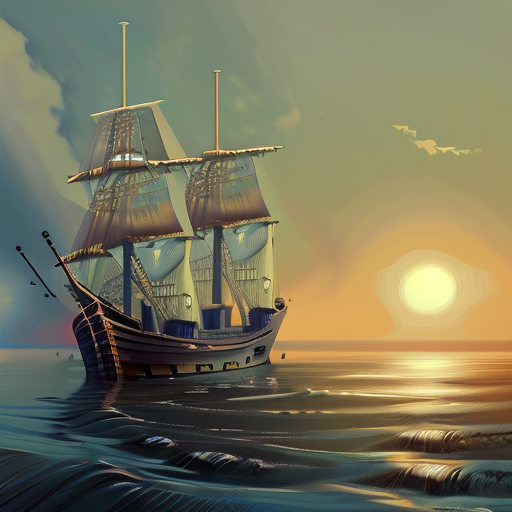

In [22]:
pare_unet = PareUNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2",).to(
	device=device,
	dtype=dtype
)

pipe.unet = pare_unet

image = pipe(prompt)
image.show()

# Part 2: Code Test

In [3]:
!pip install /notebooks/parediffusers

Processing ./parediffusers
  Preparing metadata (setup.py) ... done
  Created wheel for parediffusers: filename=parediffusers-0.1.2-py3-none-any.whl size=25560 sha256=070b5182b4fdf3b1c14e699dc828edfb392a535435072cbabba25f265108d69b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1zu5e1n6/wheels/77/ff/1e/61cb63536bbdfc32d73247e63b9d1a3c939973d88890b5e172
Successfully built parediffusers
  Attempting uninstall: parediffusers
    Found existing installation: parediffusers 0.1.2
    Uninstalling parediffusers-0.1.2:
      Successfully uninstalled parediffusers-0.1.2


In [4]:
import torch
from parediffusers import PareDiffusionPipeline

device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"

pare_pipe = PareDiffusionPipeline.from_pretrained(model_name, device=device, dtype=dtype)
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pare_pipe(prompt)
display(image)

NameError: name 'get_activation' is not defined